In [2]:
# Import necessary libraries
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import sounddevice as sd
from scipy.io.wavfile import write
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
from jiwer import wer, cer
from fpdf import FPDF
import plotly.graph_objs as go
import torch

In [3]:
# Load pre-trained Wav2Vec2 model
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-960h")

preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

c:\Users\smoni\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\smoni\.cache\huggingface\hub\models--facebook--wav2vec2-large-960h. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

In [4]:
# Set directories for data
audio_samples_dir = "data/audio_samples/"
outputs_dir = "outputs/"
os.makedirs(audio_samples_dir, exist_ok=True)
os.makedirs(outputs_dir, exist_ok=True)

In [5]:
# Load audio file
def load_audio(file_path):
    audio, sr = librosa.load(file_path, sr=16000)
    return audio, sr

In [6]:
# Plot waveform
def plot_waveform(audio, sr):
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(audio, sr=sr)
    plt.title("Waveform")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()

In [7]:
# Plot spectrogram
def plot_spectrogram(audio, sr):
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128, fmax=8000)
    spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(spectrogram_db, sr=sr, x_axis="time", y_axis="mel", cmap="coolwarm")
    plt.colorbar(format="%+2.0f dB")
    plt.title("Mel Spectrogram")
    plt.show()

In [8]:
# Record audio
def record_audio(duration=5, sample_rate=16000):
    print("Recording audio...")
    audio_data = sd.rec(int(duration * sample_rate), samplerate=sample_rate, channels=1, dtype="int16")
    sd.wait()
    audio_path = os.path.join(audio_samples_dir, "recorded_audio.wav")
    write(audio_path, sample_rate, audio_data)
    print(f"Recording complete! Audio saved at {audio_path}")
    return audio_path

In [9]:
# Transcription using Wav2Vec2
def wav2vec_transcription(audio_path):
    audio, sr = librosa.load(audio_path, sr=16000)
    input_values = processor(audio, return_tensors="pt", sampling_rate=16000).input_values
    logits = model(input_values).logits
    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = processor.decode(predicted_ids[0])
    return transcription

In [10]:
# Pronunciation metrics
def calculate_pronunciation_accuracy(reference_text, transcribed_text):
    word_error_rate = wer(reference_text, transcribed_text)
    char_error_rate = cer(reference_text, transcribed_text)
    return 1 - word_error_rate, 1 - char_error_rate

In [11]:
# Analyze pitch and energy
def analyze_pitch_and_energy(audio, sr):
    pitches, magnitudes = librosa.piptrack(y=audio, sr=sr)
    pitch_values = pitches[pitches > 0]
    pitch_mean = np.mean(pitch_values)
    pitch_std = np.std(pitch_values)
    energy = np.sum(audio**2) / len(audio)
    return pitch_values, pitch_mean, pitch_std, energy

In [12]:
# Plot pitch
def plot_pitch(audio, sr):
    pitches, magnitudes = librosa.piptrack(y=audio, sr=sr)
    time = np.linspace(0, len(audio) / sr, len(audio))
    pitch_values = [np.max(pitches[:, i]) for i in range(pitches.shape[1])]
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=time, y=pitch_values, mode="lines", name="Pitch"))
    fig.update_layout(title="Pitch Over Time", xaxis_title="Time (s)", yaxis_title="Pitch (Hz)")
    fig.show()

In [37]:
# Plot energy
def plot_energy(audio, sr):
    energy = np.sum(librosa.feature.rms(y=audio), axis=0)
    time = np.linspace(0, len(audio) / sr, len(energy))
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=time, y=energy, mode="lines", name="Energy"))
    fig.update_layout(title="Energy Over Time", xaxis_title="Time (s)", yaxis_title="Energy")
    fig.show()

In [47]:
'''
# Export PDF report
def export_pdf_report(transcription, accuracy, char_accuracy, pitch_mean, pitch_std, energy):
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font("Arial", size=12)
    pdf.cell(200, 10, txt="Speech Therapy Analysis Report", ln=True, align="C")
    pdf.ln(10)
    pdf.cell(0, 10, txt=f"Transcription: {transcription}", ln=True)
    pdf.cell(0, 10, txt=f"Word Accuracy: {accuracy * 100:.2f}%", ln=True)
    pdf.cell(0, 10, txt=f"Character Accuracy: {char_accuracy * 100:.2f}%", ln=True)
    pdf.cell(0, 10, txt=f"Mean Pitch: {pitch_mean:.2f} Hz", ln=True)
    pdf.cell(0, 10, txt=f"Pitch Standard Deviation: {pitch_std:.2f}", ln=True)
    pdf.cell(0, 10, txt=f"Energy: {energy:.2f}", ln=True)
    output_path = os.path.join(outputs_dir, "speech_analysis_report.pdf")
    pdf.output(output_path)
    print(f"Report saved at {output_path}")
    return output_path
    '''
def export_pdf_report(transcription, accuracy, char_accuracy, pitch_mean, pitch_std, energy, audio, sr):
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font("Arial", size=12)
    pdf.cell(200, 10, txt="Speech Therapy Analysis Report", ln=True, align="C")
    pdf.ln(10)

    # Add transcription
    pdf.cell(0, 10, txt=f"Transcription: {transcription}", ln=True)
    pdf.ln(10)

    # Add metrics
    pdf.cell(0, 10, txt=f"Word Accuracy: {accuracy * 100:.2f}%", ln=True)
    pdf.cell(0, 10, txt=f"Character Accuracy: {char_accuracy * 100:.2f}%", ln=True)
    pdf.cell(0, 10, txt=f"Mean Pitch: {pitch_mean:.2f} Hz", ln=True)
    pdf.cell(0, 10, txt=f"Pitch Standard Deviation: {pitch_std:.2f}", ln=True)
    pdf.cell(0, 10, txt=f"Energy: {energy:.2f}", ln=True)
    pdf.ln(10)

    # Save and embed waveform graph
    waveform_path = os.path.join(outputs_dir, "waveform.png")
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(audio, sr=sr)
    plt.title("Waveform")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.savefig(waveform_path, bbox_inches="tight")
    plt.close()
    pdf.image(waveform_path, x=10, y=None, w=180)

    # Save and embed spectrogram graph
    spectrogram_path = os.path.join(outputs_dir, "spectrogram.png")
    spectrogram_db = librosa.power_to_db(librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128, fmax=8000), ref=np.max)
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(spectrogram_db, sr=sr, x_axis="time", y_axis="mel", cmap="coolwarm")
    plt.colorbar(format="%+2.0f dB")
    plt.title("Mel Spectrogram")
    plt.savefig(spectrogram_path, bbox_inches="tight")
    plt.close()
    pdf.add_page()
    pdf.image(spectrogram_path, x=10, y=None, w=180)

    # Save and embed pitch graph
    pitch_path = os.path.join(outputs_dir, "pitch.png")
    pitches, magnitudes = librosa.piptrack(y=audio, sr=sr)
    frame_times = librosa.frames_to_time(range(pitches.shape[1]), sr=sr, hop_length=512)
    pitch_values = [np.max(pitches[:, i]) for i in range(pitches.shape[1]) if np.max(pitches[:, i]) > 0]
    plt.figure(figsize=(10, 4))
    plt.plot(frame_times[:len(pitch_values)], pitch_values, label="Pitch")
    plt.title("Pitch Over Time")
    plt.xlabel("Time (s)")
    plt.ylabel("Pitch (Hz)")
    plt.legend()
    plt.savefig(pitch_path, bbox_inches="tight")
    plt.close()
    pdf.add_page()
    pdf.image(pitch_path, x=10, y=None, w=180)

    # Save and embed energy graph
    energy_path = os.path.join(outputs_dir, "energy.png")
    energy_values = np.sum(librosa.feature.rms(y=audio), axis=0)
    frame_times = librosa.frames_to_time(range(len(energy_values)), sr=sr, hop_length=512)
    plt.figure(figsize=(10, 4))
    plt.plot(frame_times, energy_values, label="Energy", color="orange")
    plt.title("Energy Over Time")
    plt.xlabel("Time (s)")
    plt.ylabel("Energy")
    plt.legend()
    plt.savefig(energy_path, bbox_inches="tight")
    plt.close()
    pdf.add_page()
    pdf.image(energy_path, x=10, y=None, w=180)

    # Save the PDF report
    output_path = os.path.join(outputs_dir, "speech_analysis_report_with_graphs.pdf")
    pdf.output(output_path)
    print(f"Report saved at {output_path}")
    return output_path


Speech Therapy Project
Recording audio...
Recording complete! Audio saved at data/audio_samples/recorded_audio.wav


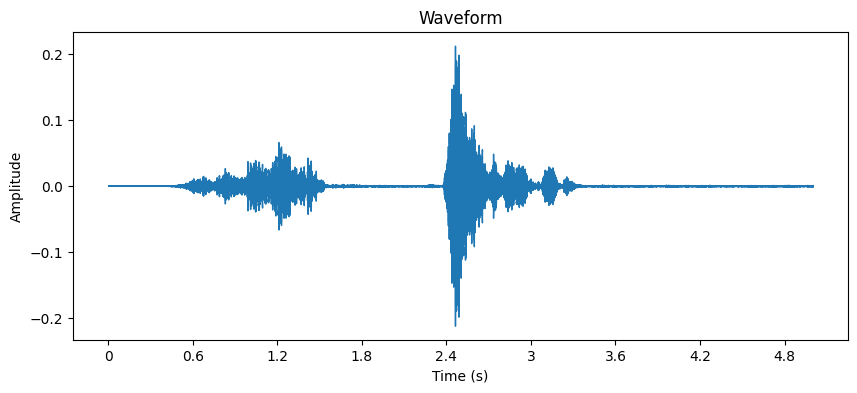

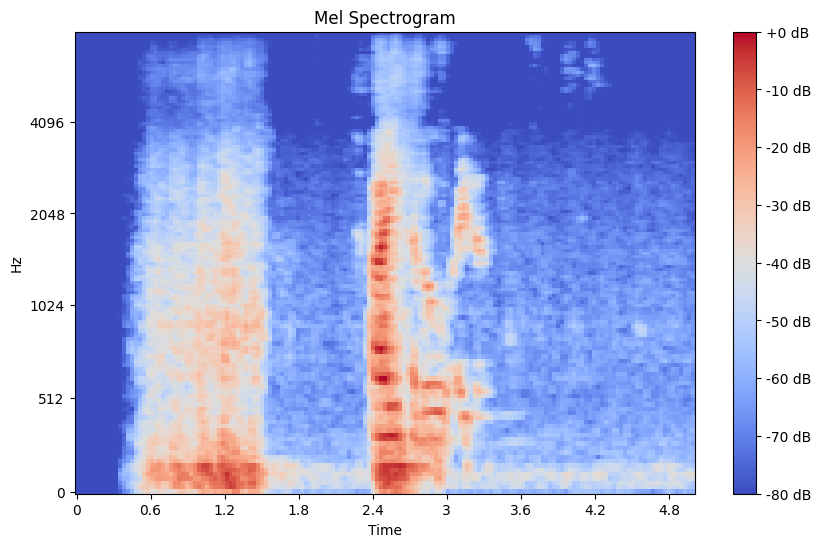

Transcription: I HAD ALRE EM
Word Accuracy: 0.00%
Character Accuracy: 9.38%
Mean Pitch: 1321.86 Hz
Pitch Std Dev: 1062.41
Energy: 0.00


Report saved at outputs/speech_analysis_report_with_graphs.pdf


In [48]:
'''
# Example workflow
if __name__ == "__main__":
    print("Speech Therapy Project")

    # Record audio
    audio_path = record_audio(duration=5)

    # Load audio
    audio, sr = load_audio(audio_path)
    plot_waveform(audio, sr)
    plot_spectrogram(audio, sr)

    # Transcription
    transcription = wav2vec_transcription(audio_path)
    print("Transcription:", transcription)

    # Metrics
    reference_text = "Provide your reference text here"
    accuracy, char_accuracy = calculate_pronunciation_accuracy(reference_text, transcription)
    print(f"Word Accuracy: {accuracy * 100:.2f}%")
    print(f"Character Accuracy: {char_accuracy * 100:.2f}%")

    # Pitch and energy analysis
    pitch_values, pitch_mean, pitch_std, energy = analyze_pitch_and_energy(audio, sr)
    print(f"Mean Pitch: {pitch_mean:.2f} Hz")
    print(f"Pitch Std Dev: {pitch_std:.2f}")
    print(f"Energy: {energy:.2f}")

    # Plot pitch and energy
    plot_pitch(audio, sr)
    plot_energy(audio, sr)

    # Export PDF report
    export_pdf_report(transcription, accuracy, char_accuracy, pitch_mean, pitch_std, energy)
'''
# Example workflow
if __name__ == "__main__":
    print("Speech Therapy Project")

    # Record audio
    audio_path = record_audio(duration=5)

    # Load audio
    audio, sr = load_audio(audio_path)
    plot_waveform(audio, sr)
    plot_spectrogram(audio, sr)

    # Transcription
    transcription = wav2vec_transcription(audio_path)
    print("Transcription:", transcription)

    # Metrics
    reference_text = "Provide your reference text here"
    accuracy, char_accuracy = calculate_pronunciation_accuracy(reference_text, transcription)
    print(f"Word Accuracy: {accuracy * 100:.2f}%")
    print(f"Character Accuracy: {char_accuracy * 100:.2f}%")

    # Pitch and energy analysis
    pitch_values, pitch_mean, pitch_std, energy = analyze_pitch_and_energy(audio, sr)
    print(f"Mean Pitch: {pitch_mean:.2f} Hz")
    print(f"Pitch Std Dev: {pitch_std:.2f}")
    print(f"Energy: {energy:.2f}")

    # Plot pitch and energy
    plot_pitch(audio, sr)
    plot_energy(audio, sr)

    # Export PDF report with graphs
    export_pdf_report(
        transcription=transcription,
        accuracy=accuracy,
        char_accuracy=char_accuracy,
        pitch_mean=pitch_mean,
        pitch_std=pitch_std,
        energy=energy,
        audio=audio,
        sr=sr
    )

